# Supervised Learning

In this notebook we attempt to solve the topic extraction problem by using Decision Trees as a supervised learning algorithm.

## Data setup

In [34]:
# Import libraries needed
from math import pow
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

### Data setup

Like with the unsupervised learning, we split the "BBC News Train.csv" file into two "train" and "test" sets. We then use TD-IDF and vectorize the texts into a sparse matrix for modeling

In [35]:
# Read dataset and create training an testing datasets
bbc_training_set = pd.read_csv('./Data/BBC News Train.csv')
feature_data = bbc_training_set.drop(columns=["Category"])
X_train, X_test, Y_train, Y_test = train_test_split(feature_data, bbc_training_set["Category"], test_size=0.2)

In [36]:
# Vectorize training dataset usinf TF-IDF
vect = TfidfVectorizer(min_df=10, stop_words='english')
vect_train_data = vect.fit_transform(X_train["Text"])
vect_test_data = vect.transform(X_test["Text"])

## Support functions

The `get_tree_description()` function is used to print out the tree's structure.

In [37]:
def get_tree_description(tree, features):
    '''
    Prints out the structure of a decision tree, identifying node depths and split conditions.
    Original code at https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    '''

    # Store tree attributes
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    
    # Get decision output for tree nodes
    labels = []
    for value in tree.tree_.value:
        labels.append(tree.classes_[np.argmax(value)])

    # Initialize support arrays
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    # start with the root node id (0) and its depth (0)
    stack = [(0, 0)]  

    # While there are still nodes to visit
    while len(stack) > 0:

        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split node
        is_split_node = children_left[node_id] != children_right[node_id]

        # If a split node, 
        if is_split_node:
            # append left and right children and depth to `stack`
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            # Otherwise, identify as leaf
            is_leaves[node_id] = True

    # Print number of nodes
    print("The binary tree structure has {n} nodes and has the following tree structure:\n".format(n=n_nodes))
    
    # Print tree structure
    # For each node in the tree
    for i in range(n_nodes):

        # If node is a leaf, print its index and output class
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with label={label}.".format(
                    space=node_depth[i] * "\t", node=i, label=labels[i]
                )
            )
        # Otherwise, 
        else:
            # Print node index, left node, right node and split condition
            print(
                "{space}node={node} is a split node: go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=features[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )

    # Get a list of classes as strings
    str_classes = [str(label) for label in tree.classes_]
    
    # Set plot size
    plt.figure(figsize=(pow(2, 6), pow(2, 6)))

    # Plot tree structure
    plot_tree(tree, feature_names=features, class_names=str_classes, filled=True, node_ids=True, rounded=True)
    plt.show()

## Model Creation

We create a preliminary Decision Tree Classifier with a ccp_alpha of 0.

In [38]:
# Create a Decision Tree and fit it to training data and predict toppics for the testing data
dt = DecisionTreeClassifier(ccp_alpha=0.0).fit(vect_train_data, Y_train)
predictions = dt.predict(vect_test_data)

# Calculate and print a confusion matrix for predictions
conf_matrix = confusion_matrix(Y_test, predictions)
print("\n\nModel's Confusion Matrix")
print(conf_matrix)


# Calculate model's accuracy
correct = 0
for i in range(len(conf_matrix)):
    correct += conf_matrix[i][i]
accuracy = correct / len(Y_test)

print("\n")
print("Correctly predicted topics: ", correct)
print("Incorrectly predicted topics: ", len(Y_test) - correct)
print("Model's accuracy: ", accuracy)



Model's Confusion Matrix
[[46  4  2  3  8]
 [ 2 26  6  7  1]
 [ 3  4 46  3  2]
 [ 1  2  1 70  3]
 [ 5  1  3  1 48]]


Correctly predicted topics:  236
Incorrectly predicted topics:  62
Model's accuracy:  0.7919463087248322


The binary tree structure has 233 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if labour <= 0.01116932276636362 else to node 220.
	node=1 is a split node: go to node 2 if film <= 0.03189951740205288 else to node 209.
		node=2 is a split node: go to node 3 if win <= 0.021130762994289398 else to node 184.
			node=3 is a split node: go to node 4 if users <= 0.010629427619278431 else to node 179.
				node=4 is a split node: go to node 5 if music <= 0.008483342826366425 else to node 166.
					node=5 is a split node: go to node 6 if market <= 0.032120369374752045 else to node 149.
						node=6 is a split node: go to node 7 if mr <= 0.007956413552165031 else to node 98.
							node=7 is a split node: go to node 8 if economy <= 0.014559563249349594 else to node 97.
								node=8 is a split node: go to node 9 if company <= 0.03607741370797157 else to node 82.
									node=9 is a split node: go to node 10 if tv <= 0.049990344792604446 else to node 79.
					

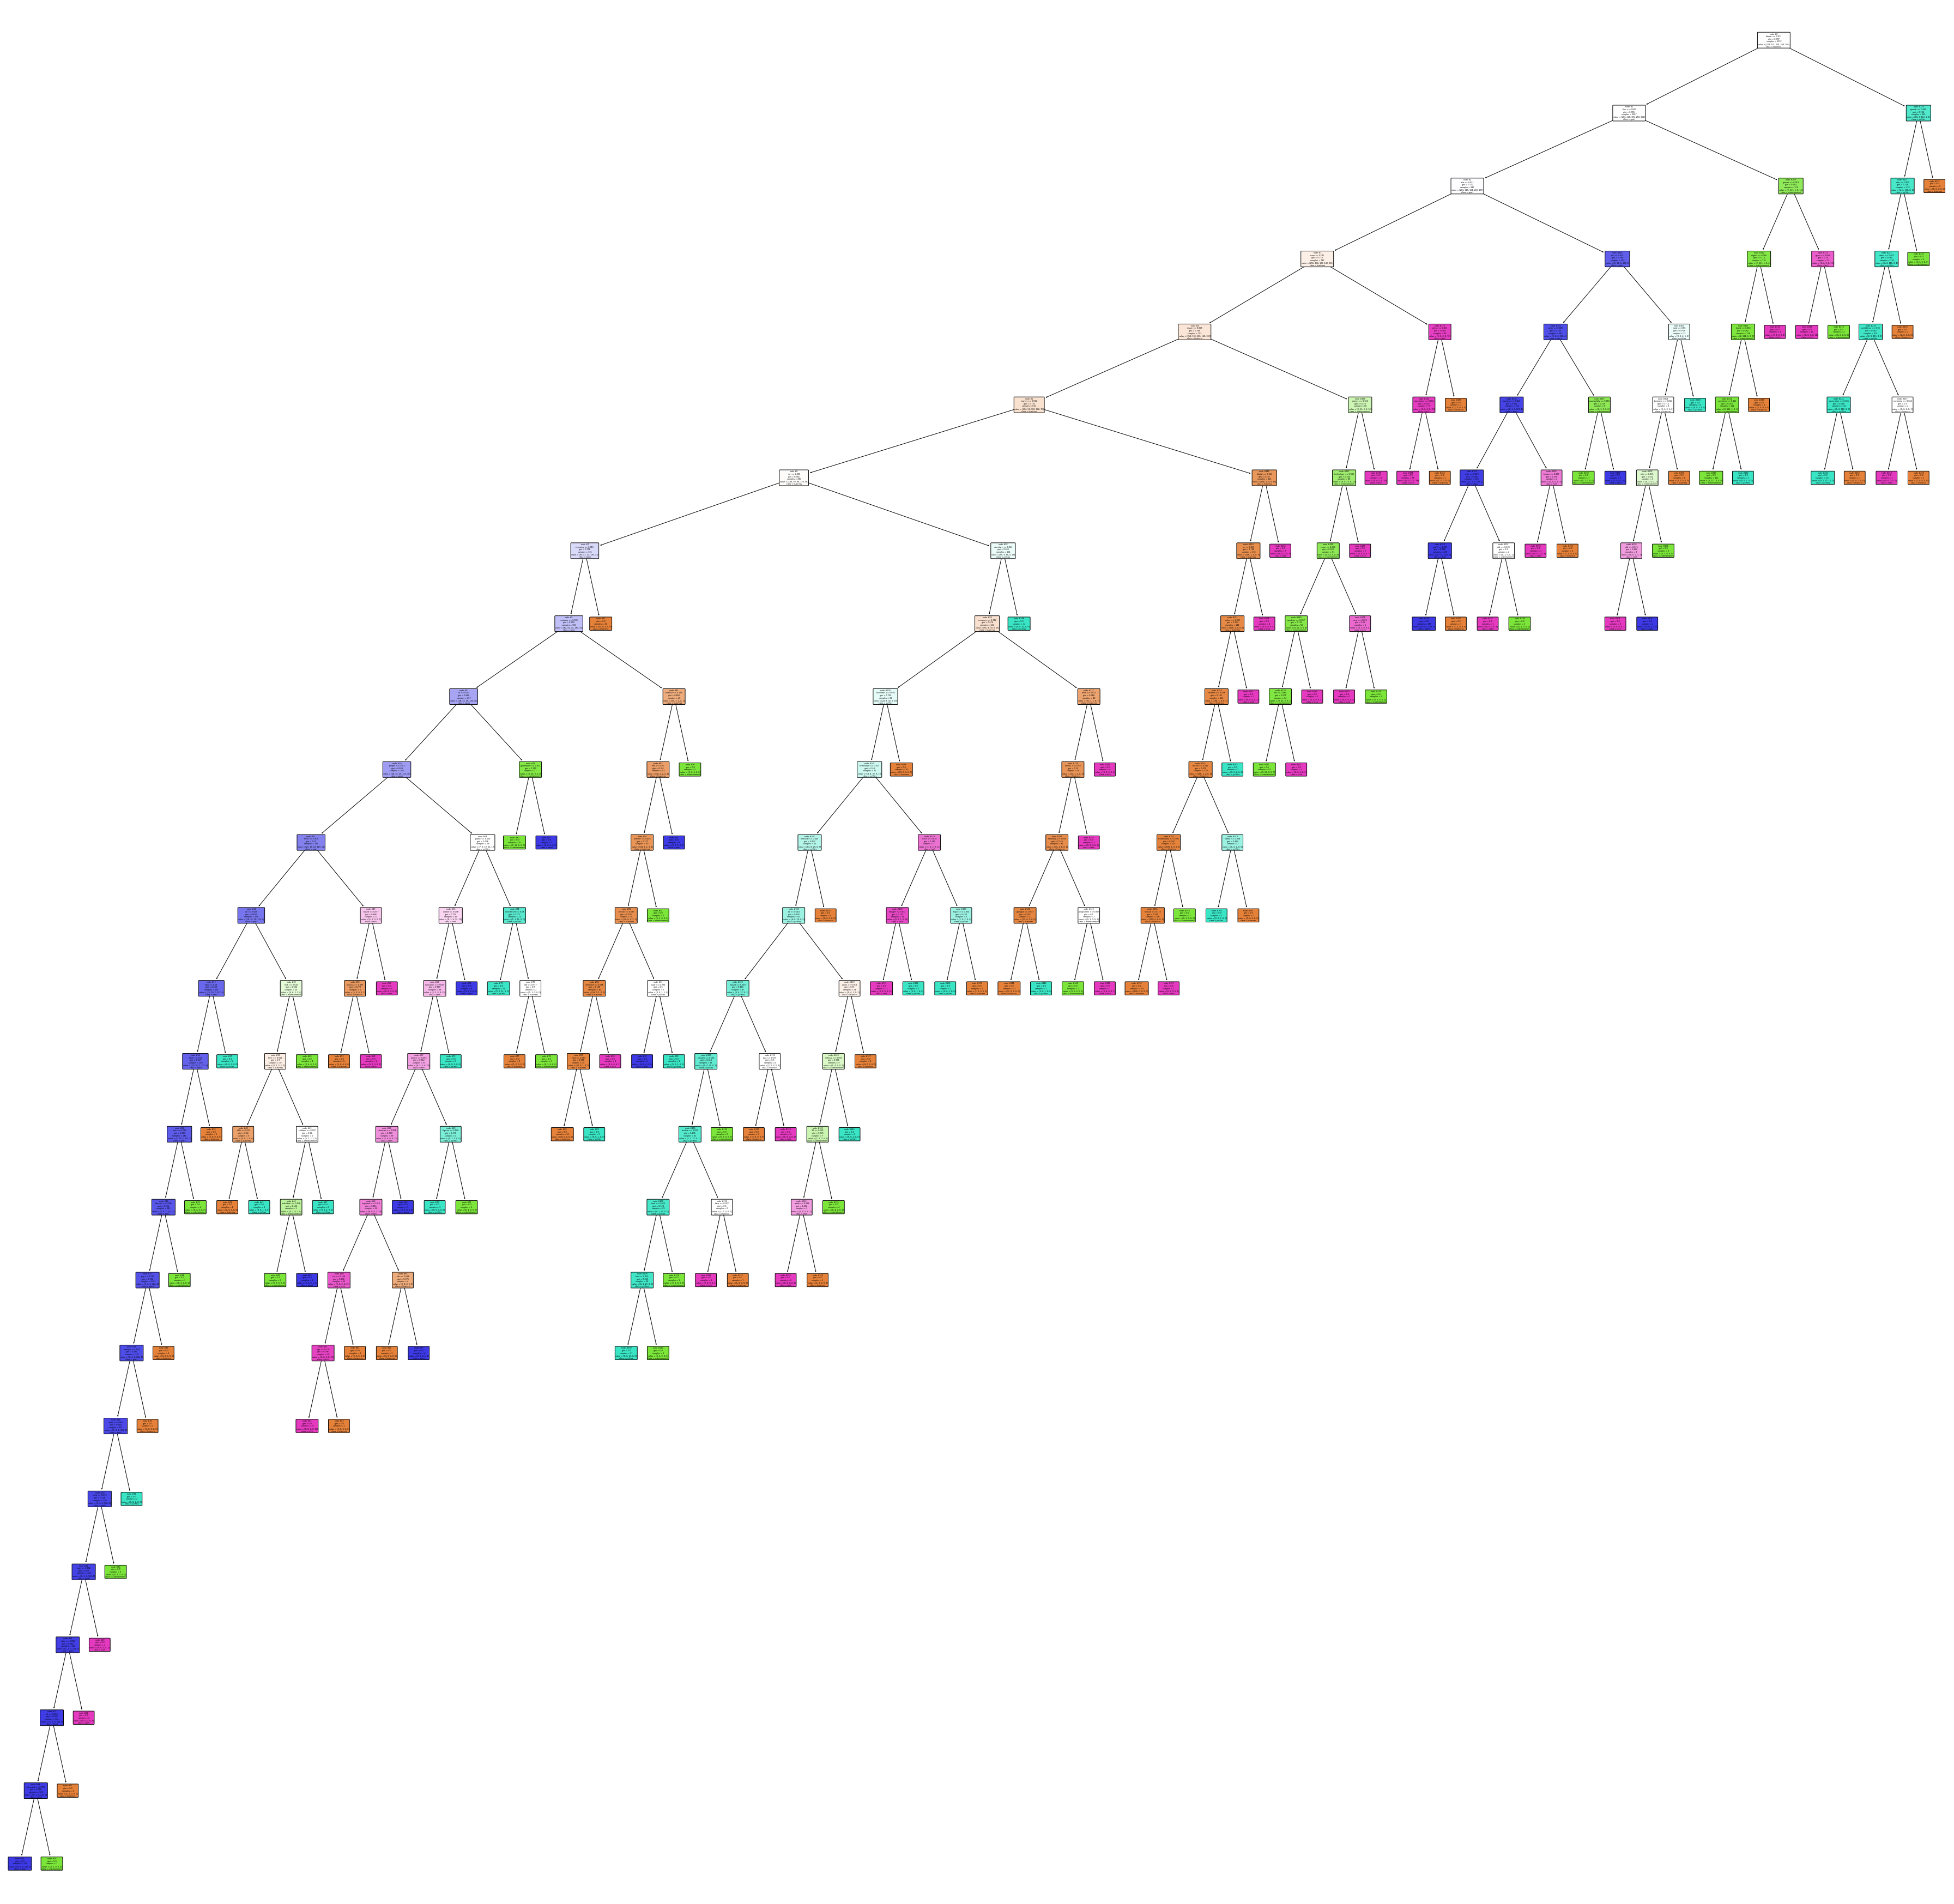

In [39]:
# Print tree's description and plot its graph
get_tree_description(dt, vect.get_feature_names_out())

## Model reduction (Cost Complexity Pruning)

We can use the cost_complexity_pruning_path() function to obtain a set of possible ccp_alpha values with which to train our Decision Tree Classifier

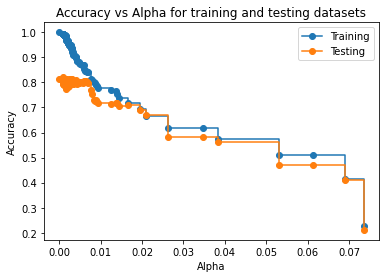

In [40]:
# Apply Cost Complexity Pruning to model
path = dt.cost_complexity_pruning_path(vect_train_data,Y_train)         # Post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities       # Get ccp_alphas and node impurities

# Create a vector with new classifiers for each alpha 
clfs = [DecisionTreeClassifier(ccp_alpha=alpha).fit(vect_train_data, Y_train) for alpha in ccp_alphas]
    
# Create a list of training and testing scores
train_scores = []
test_scores = []

# For each classifier, store training and testing scores
for clf in clfs:
    train_scores.append(clf.score(vect_train_data, Y_train))
    test_scores.append(clf.score(vect_test_data, Y_test))

# Plot Accuracy vs Alpha
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha for training and testing datasets")
ax.plot(ccp_alphas, train_scores, marker='o', label="Training", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="Testing", drawstyle="steps-post")
ax.legend()
plt.show() 



In [41]:
# Print Table header
print("Index", "\t", "Alpha", "\t", "\t", "\t",  "Depth", "\t", "Node Count", "\t", "Training score", "\t", "Testing Score")

# Print the index, alpha, depth, node count and scores for all trees
for i in range(len(ccp_alphas)):
    print(i, "\t", f'{ccp_alphas[i]:.19f}', "\t", clfs[i].get_depth(), "\t", clfs[i].tree_.node_count,
            "\t","\t", f'{train_scores[i]:.19f}', "\t", f'{test_scores[i]:.19f}')

Index 	 Alpha 	 	 	 Depth 	 Node Count 	 Training score 	 Testing Score
0 	 0.0000000000000000000 	 25 	 233 	 	 1.0000000000000000000 	 0.8120805369127517270
1 	 0.0008389261744966443 	 25 	 217 	 	 0.9924496644295301984 	 0.8087248322147650992
2 	 0.0008389261744966443 	 25 	 215 	 	 0.9941275167785235123 	 0.8087248322147650992
3 	 0.0008389261744966443 	 25 	 217 	 	 0.9949664429530201692 	 0.8020134228187919545
4 	 0.0008389261744966443 	 25 	 219 	 	 0.9941275167785235123 	 0.8221476510067113885
5 	 0.0008389261744966443 	 25 	 215 	 	 0.9924496644295301984 	 0.8087248322147650992
6 	 0.0008389261744966443 	 25 	 213 	 	 0.9932885906040268553 	 0.8053691275167784713
7 	 0.0008389261744966443 	 25 	 213 	 	 0.9924496644295301984 	 0.7953020134228188098
8 	 0.0008389261744966443 	 25 	 219 	 	 0.9949664429530201692 	 0.7919463087248321820
9 	 0.0008389261744966443 	 25 	 217 	 	 0.9941275167785235123 	 0.8087248322147650992
10 	 0.0011185682326621924 	 25 	 201 	 	 0.98741610738255

As we can see, Decision Trees trained for topic modeling tends to overfit according to the training data. This is due to the model's algorithm, in which the node splits are made based on a single word, instead of taking into account all words within the document.

As such, the Decision Tree with the best testing score (Tree 4 - Test score of 0.822 with 219 nodes) had a comparable result against much smaller trees, such as Tree 80 (Test score of 0.802 with only 51 nodes).

The binary tree structure has 51 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if labour <= 0.01116932276636362 else to node 48.
	node=1 is a split node: go to node 2 if film <= 0.03189951740205288 else to node 45.
		node=2 is a split node: go to node 3 if win <= 0.021130762994289398 else to node 40.
			node=3 is a split node: go to node 4 if users <= 0.010629427619278431 else to node 39.
				node=4 is a split node: go to node 5 if music <= 0.008483342826366425 else to node 32.
					node=5 is a split node: go to node 6 if market <= 0.032120369374752045 else to node 29.
						node=6 is a split node: go to node 7 if mr <= 0.007956413552165031 else to node 20.
							node=7 is a split node: go to node 8 if economy <= 0.014559563249349594 else to node 19.
								node=8 is a split node: go to node 9 if company <= 0.03607741370797157 else to node 18.
									node=9 is a split node: go to node 10 if tv <= 0.049990344792604446 else to node 17.
										no

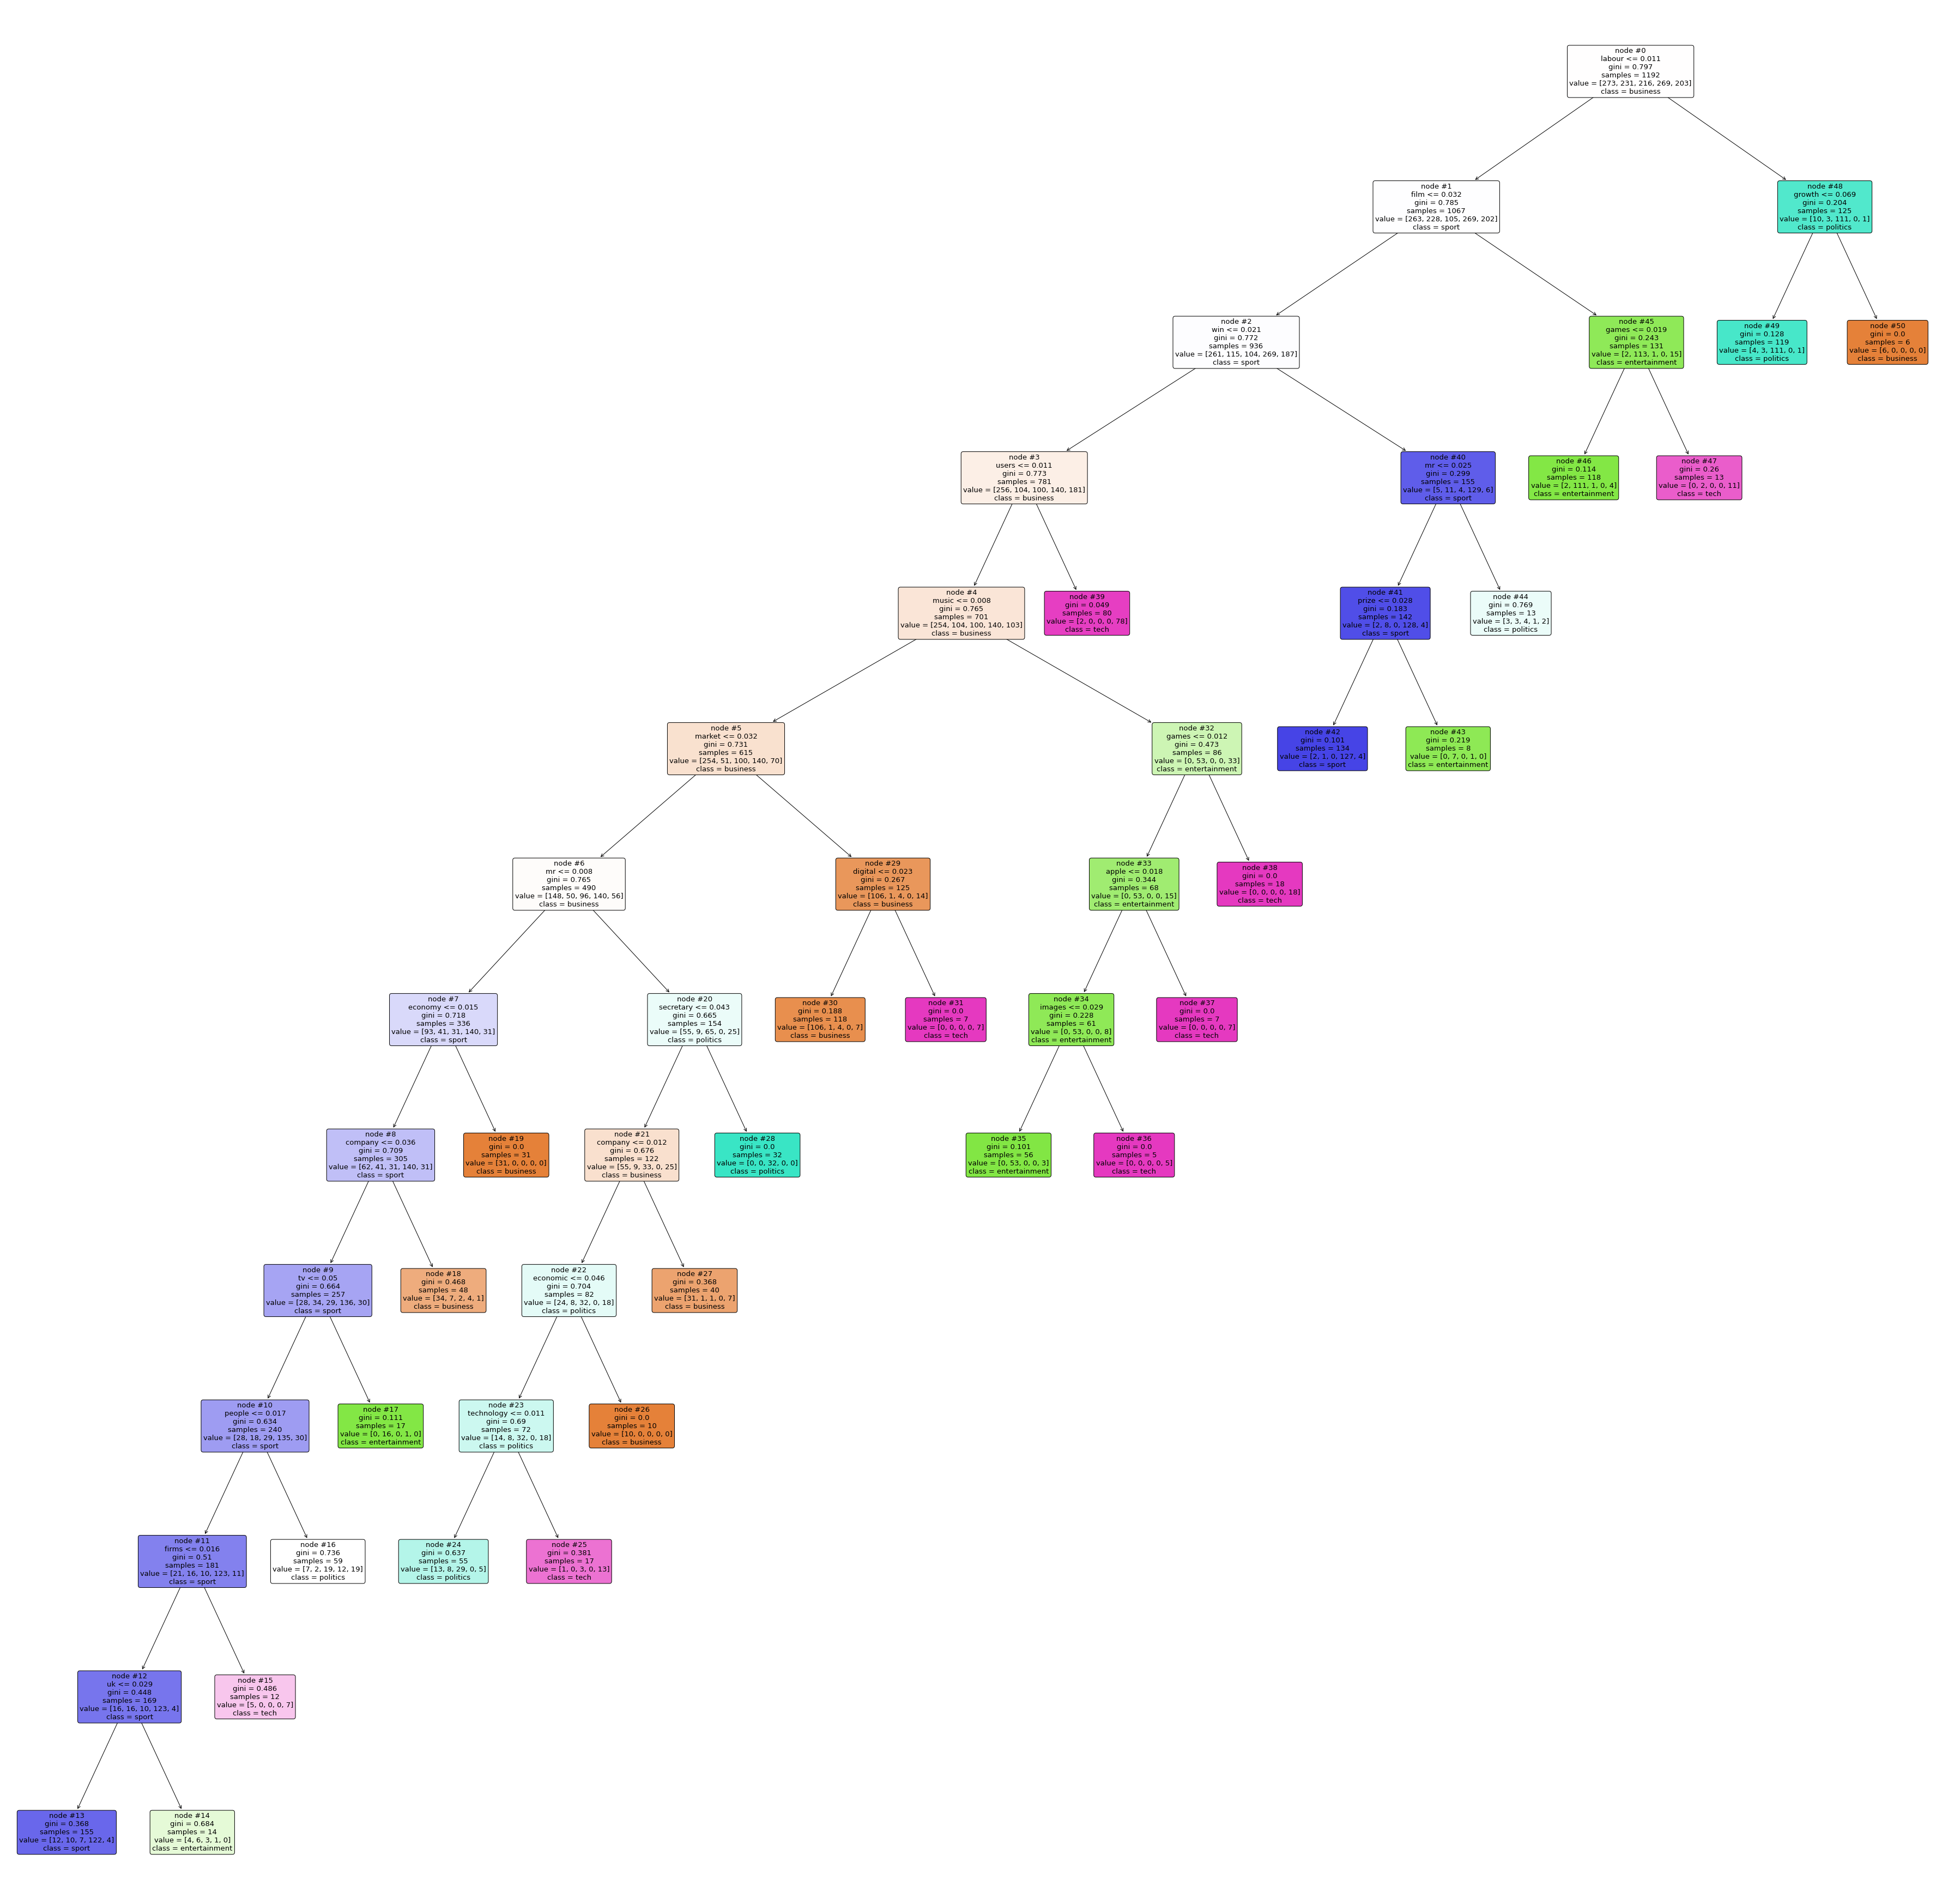

In [47]:
# Get description and plot for 23rd Decision Tree
get_tree_description(clfs[80], vect.get_feature_names_out())

### Kaggle BBC News Solution

Given the best hyperparameters extracted above, we can use Decision Tree 4 to read the "BBC News Test.csv" file and predict each article's category.

In [46]:
# Create a new model with the best hyperparameters fitted on the full training dataset
bbc_testing_set = pd.read_csv('./Data/BBC News Test.csv')
bbc_test_data = vect.transform(bbc_testing_set["Text"])
bbc_testing_predictions = clfs[4].predict(bbc_test_data)
list(bbc_testing_predictions)

['sport',
 'business',
 'sport',
 'business',
 'sport',
 'sport',
 'politics',
 'entertainment',
 'entertainment',
 'politics',
 'business',
 'tech',
 'politics',
 'tech',
 'entertainment',
 'sport',
 'entertainment',
 'tech',
 'entertainment',
 'entertainment',
 'business',
 'politics',
 'sport',
 'business',
 'tech',
 'sport',
 'tech',
 'sport',
 'sport',
 'business',
 'politics',
 'entertainment',
 'business',
 'business',
 'sport',
 'sport',
 'sport',
 'business',
 'entertainment',
 'entertainment',
 'tech',
 'politics',
 'entertainment',
 'tech',
 'sport',
 'politics',
 'entertainment',
 'business',
 'politics',
 'business',
 'sport',
 'business',
 'politics',
 'business',
 'tech',
 'business',
 'tech',
 'entertainment',
 'sport',
 'tech',
 'sport',
 'entertainment',
 'tech',
 'politics',
 'entertainment',
 'entertainment',
 'sport',
 'sport',
 'sport',
 'sport',
 'business',
 'sport',
 'business',
 'politics',
 'tech',
 'sport',
 'business',
 'entertainment',
 'tech',
 'sport',
 

A expected, the Decision Tree with the best score achieved a poor result for the topic prediction to testing articles, not even reaching an 80% accuracy.

![Alt text](image-2.png)

## Results

Although a Decision Tree Classifier may achieve a high or even perfect score during training, its decision algorithm makes it succeptible to overfitting, resulting in models with a much lower accuracy during testing. As seen above, using Cost Complexity Pruning will not have a large impact on the model accuracy, as most decisions are taken within the first few levels. However, its use allows us to obtain smaller trees with similar working accuracy.

The models' low accuracy does not mean that Decision Trees do not have any uses. The simplicity in its decision algorithm allows for it to be trained in a very small amount of data. This could be used, for example to assign preliminary labels to a much larger dataset that will be used to train a more complex model. If said model then uses a mayority votign strategy to determine the final labels, an accuraccy of 75%-80% by the Decision Tree as seen here may be sufficient to obtain accurate results with the final model.